In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib notebook

In [22]:
FTSEStocksEachQuarter = pd.read_csv(r'FTSEStocksEachQuarter.csv')
fullStockListDf = pd.read_csv(r'fullFTSEStockList17-20.csv')
fullStockListDf.drop(columns = 'Unnamed: 0', inplace = True)

FTSE = pd.read_csv(r'FTSE17-20.csv')
FTSE['Date'] = pd.to_datetime(FTSE['Date'])
FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
FTSE=FTSE[FTSE['Date'] < datetime.strptime('Jan 01, 2020', '%b %d, %Y').date()]


quarterCutOffDates = [   datetime.strptime('Jun 19, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 19, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 18, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 18, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 24, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 23, 2019', '%b %d, %Y').date(),
                          datetime.strptime('Dec 23, 2019', '%b %d, %Y').date()
                        ]
quarterNames = ['Q3,17','Q4,17', 'Q1,18', 'Q2,18', 'Q3,18', 'Q4,18', 'Q1,19', 'Q2,19', 'Q3,19', 'Q4,19']


FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
if len(quarterCutOffDates) == 10:
    quarterCutOffDates.append(datetime.strptime('Dec 23, 2019', '%b %d, %Y').date())

indexDivisors = pd.DataFrame({'Quarter CO Date': quarterCutOffDates[1:]}, index = quarterNames)
fullStockListDf

,0
0,AAL
1,ABF
2,ADM
3,AHT
4,ANTO
...,...
110,UU.
111,VOD
112,WG.
113,WPP


# Tilt Function 
Input : DataFrame with companies as index names and tilt weights (-2% > tilt > 2%) in 'Weights' column

see below function for example

In [26]:
def tiltFTSE(tilt):
    #iterates over quarter in period
    for idx, quarter in enumerate(quarterNames):
        #gets index (trading days) for each quarter
        index = FTSE[(FTSE['Date'] >= quarterCutOffDates[idx]) & (FTSE['Date'] < quarterCutOffDates[idx+1])].Date.values

        #imports data for that quarter
        stockWeightsOpen = pd.read_csv(r'companyWeightsEachQuarter/companyWeights{0}Open.csv'.format(quarter))
        stockWeightsOpen.drop(columns = 'Unnamed: 0', inplace = True)

        stockWeightsClose = pd.read_csv(r'companyWeightsEachQuarter/companyWeights{0}Close.csv'.format(quarter))
        stockWeightsClose.drop(columns = 'Unnamed: 0', inplace = True)

        totalMCsOpen = pd.read_csv(r'totalMarketCapsEachQuarter/totalMarketCaps{0}Open.csv'.format(quarter))
        totalMCsOpen.drop(columns = 'Unnamed: 0', inplace = True)

        totalMCsClose = pd.read_csv(r'totalMarketCapsEachQuarter/totalMarketCaps{0}Close.csv'.format(quarter))
        totalMCsClose.drop(columns = 'Unnamed: 0', inplace = True)

        stockMarketCapsEachQuarterOpen = pd.read_csv(r'companyMarketCapsEachQuarter/companyMarketCaps{0}Open.csv'.format(quarter))
        stockMarketCapsEachQuarterOpen.drop(columns = 'Unnamed: 0', inplace = True)

        stockMarketCapsEachQuarterClose = pd.read_csv(r'companyMarketCapsEachQuarter/companyMarketCaps{0}Close.csv'.format(quarter))
        stockMarketCapsEachQuarterClose.drop(columns = 'Unnamed: 0', inplace = True)

        #iterates over each stock in the FTSE that quarter
        for stock in FTSEStocksEachQuarter[quarter]:
            #adds tilt from aray to the company weight
            stockWeightsOpen[stock] = stockWeightsOpen[stock].add(tilt.loc[stock][0])
            stockWeightsClose[stock] = stockWeightsClose[stock].add(tilt.loc[stock][0])

        #if weight is <0 then set to 0
        stockWeightsOpen[stockWeightsOpen < 0] = 0
        stockWeightsClose[stockWeightsClose < 0] = 0

        #calculates effective market caps using new weight and old market caps 
        newMarketCapsOpen = stockWeightsOpen*stockMarketCapsEachQuarterOpen.values
        newMarketCapsClose = stockWeightsClose*stockMarketCapsEachQuarterClose.values

        #calculates new total market cap each day
        newTotalMarketCapsOpen = newMarketCapsOpen.sum(axis=1).to_frame()
        newTotalMarketCapsClose = newMarketCapsClose.sum(axis=1).to_frame()

        #calculates index divisor to make sure price stays continuous over the change in quarter
        if idx == 0:
            #for the first quarter the reference price is the real FTSE price from that day - abitrary starting point
            indexDivisorForQuarter = newTotalMarketCapsOpen.values[0][0]/(FTSE[FTSE['Date'] == quarterCutOffDates[idx]]['Open'].values[0])
        else:
            indexDivisorForQuarter = newTotalMarketCapsOpen.values[0][0]/FTSEPriceQuarterly['Close'].values[-1]


        #calculates new tilted price using index divisor and tilted market caps

        FTSEPriceQuarterly = newTotalMarketCapsOpen.divide(indexDivisorForQuarter).set_index(index, drop=True)
        FTSEPriceQuarterly.rename(columns={0:"Open"}, inplace=True)
        FTSEPriceQuarterly['Close'] = newTotalMarketCapsClose.divide(indexDivisorForQuarter).set_index(index, drop=True)


        if idx == 0:
            FTSEPrice3yr = FTSEPriceQuarterly

        else:
            FTSEPrice3yr = FTSEPrice3yr.append(FTSEPriceQuarterly)


    
    return FTSEPrice3yr
   

Example Input

In [27]:
tiltWeights = pd.DataFrame(index = fullStockListDf['0'].values)
tiltWeights['Weights'] = np.random.uniform(-2,2,tiltWeights.shape[0])
tiltWeights

,Weights
AAL,-1.891592
ABF,1.578561
ADM,-1.832752
AHT,0.848898
ANTO,1.612408
...,...
UU.,0.371980
VOD,-1.736249
WG.,0.340766
WPP,-1.251959


In [28]:
tiltedFTSE = tiltFTSE(tiltWeights)
print(tiltedFTSE)

                   Open        Close
2017-06-19  7463.500000  7480.210103
2017-06-20  7488.861846  7415.778267
2017-06-21  7408.113749  7364.859154
2017-06-22  7360.125417  7363.989214
2017-06-23  7346.500644  7340.713241
...                 ...          ...
2019-12-16  7587.593716  7704.530929
2019-12-17  7691.036825  7747.010597
2019-12-18  7730.596615  7762.508542
2019-12-19  7773.082063  7816.821259
2019-12-20  7814.615988  7839.688771

[638 rows x 2 columns]


<IPython.core.display.Javascript object>


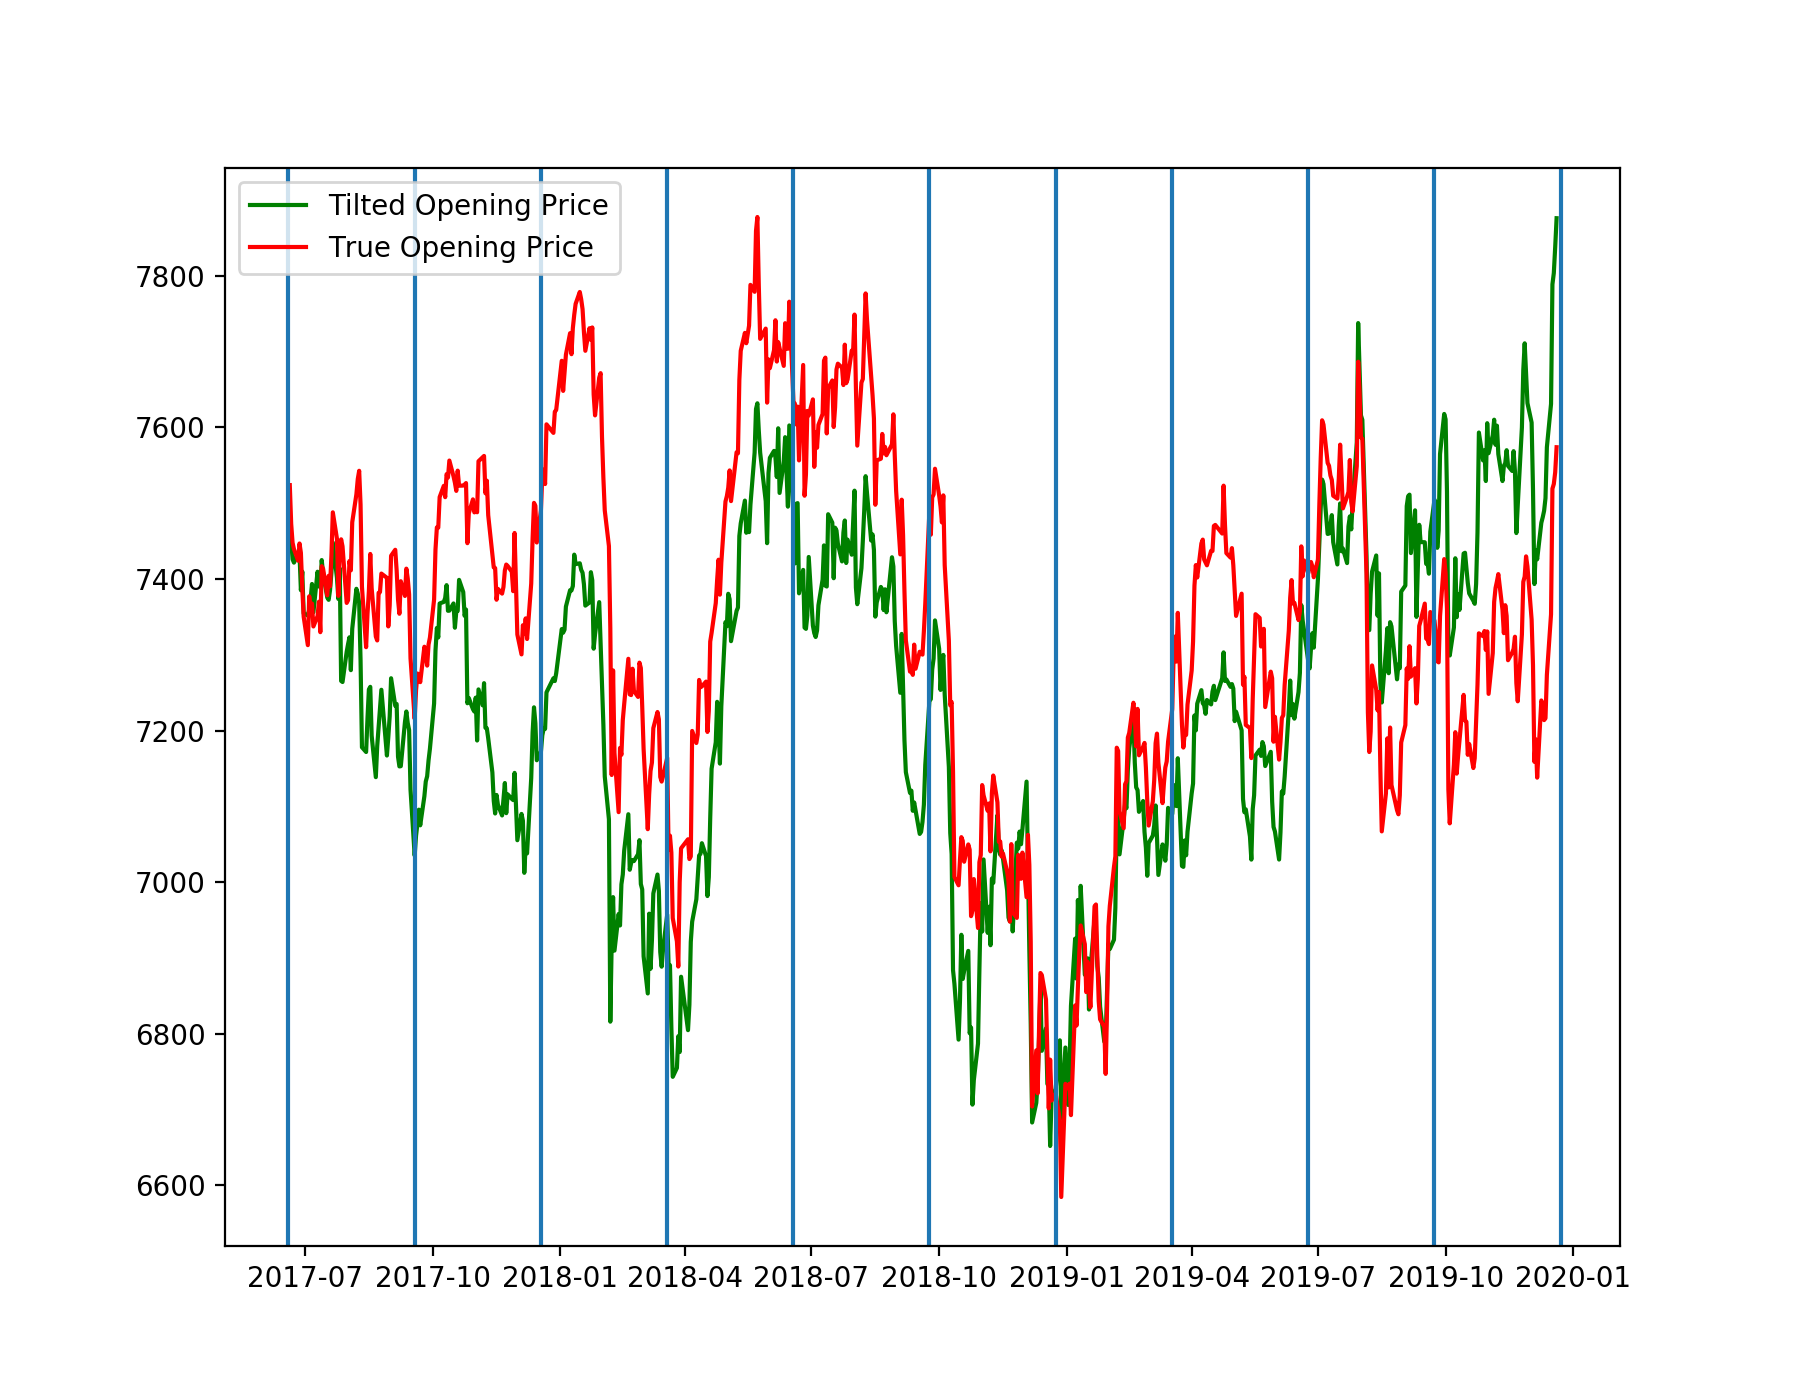

In [30]:
FTSEq317 = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Open'].values
FTSEq317date = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Date'].values

f = plt.figure(figsize=(9,7))
axs = f.add_subplot(111)
axs.plot(FTSEPrice3yr.index.values,FTSEPrice3yr['Open'].values,'g', label = 'Tilted Opening Price')
axs.plot(FTSEq317date,FTSEq317,'r', label = 'True Opening Price')
axs.legend()
for quarter in quarterCutOffDates:
    axs.axvline(x=quarter)